<a href="https://colab.research.google.com/github/JaccoVeldscholten/SmartDispenser/blob/main/BAVA_Temp_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
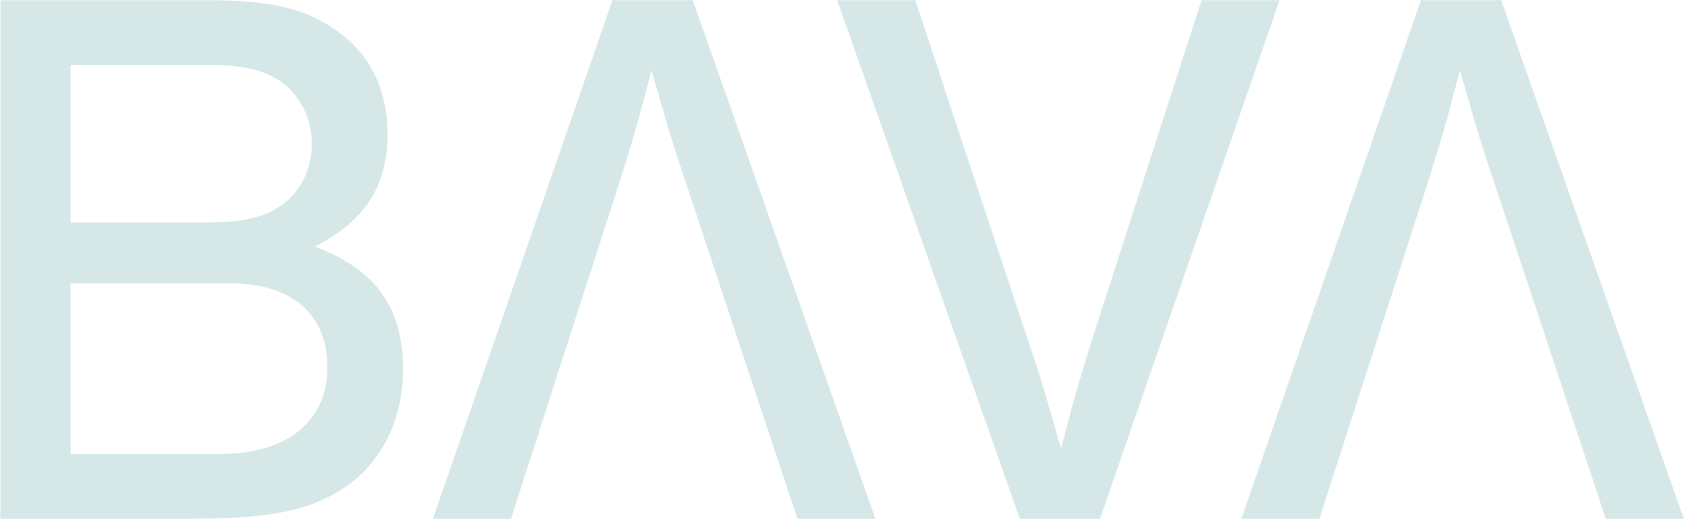
</div>

**API Validation & Prediction** <br>
This document will be validate the gathered API Data and will is able to being used for predictions and analyses

***Temperature Prediction*** <br>
To start off Machine Learning is being used to predict the temperature of the certain amount of days in the toilet. By using basic regression model (linear) its possible to predict the temperature based on the API data thats being generated by the device.

# Imports <br>
In the first stage of the notebook all imports should be made for running the code later on in the notebook

In [4]:
import urllib.request
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import datetime

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

# Disable copy warn
pd.options.mode.chained_assignment = None  # default='warn'

2.7.0


# Fetching API <br>
First gather the API Data from the URL. After that print the first elements of the fetched data

In [5]:
with urllib.request.urlopen("https://us-central1-bava-solutions.cloudfunctions.net/GetAllDeviceData") as url:
    data = json.loads(url.read().decode())

In [6]:
df = pd.DataFrame(data)
df.tail()
# df['timestamp'][0]

,batteryLevel,temp,tvoc_ppm,liquidLevel,altitude,occupied,pressure,timestamp,hum,mac,tvoc_co2
88,100,19,1,100,143,False,99672,"{'_seconds': 1638422509, '_nanoseconds': 70700...",36,F0:08:D1:D8:07:D4,155
89,100,19,1,100,143,False,99679,"{'_seconds': 1638422810, '_nanoseconds': 57100...",36,F0:08:D1:D8:07:D4,155
90,100,19,0,100,142,True,99682,"{'_seconds': 1638423041, '_nanoseconds': 52900...",36,F0:08:D1:D8:07:D4,144
91,100,19,0,100,142,True,99684,"{'_seconds': 1638423111, '_nanoseconds': 65200...",36,F0:08:D1:D8:07:D4,144
92,100,19,8,100,142,True,99682,"{'_seconds': 1638423192, '_nanoseconds': 21600...",36,F0:08:D1:D8:07:D4,198


# Plotting the data

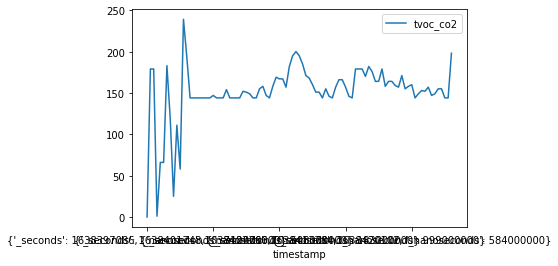

In [7]:
df.plot(x='timestamp', y='tvoc_co2')

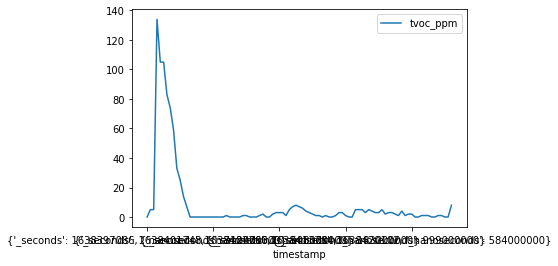

In [8]:
# Reading TVOC
df = pd.DataFrame(data)
df.plot(x='timestamp', y='tvoc_ppm')

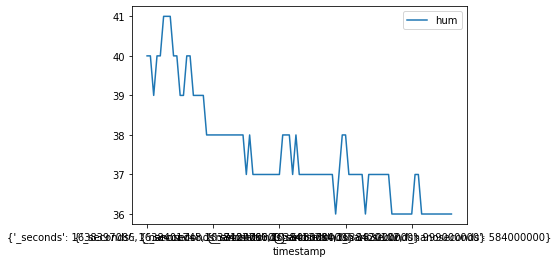

In [9]:
# Reading humidty
df.plot(x='timestamp', y='hum')

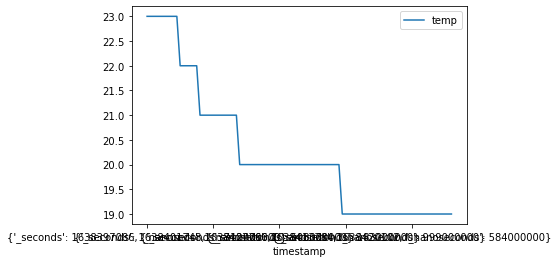

In [10]:
# Reading temperature
df.plot(x='timestamp', y='temp')

# The numbers mason <br>
The numbers mason what do they mean?

In [11]:
# Getting all triggers by occupation
triggerd_by_occupation = df[df['occupied']==1]
triggerd_by_occupation.count()['occupied']

10

In [12]:
# Getting all triggers by timer
triggerd_by_timer = df[df['occupied']==0]
triggerd_by_timer.count()['occupied']

83

# Predictions <br>
**Predictions based on Machine learning data**<br> 
First prediction is determining what the temperature might be in a few days.


In [13]:
# Tensorflow
np.set_printoptions(precision=3, suppress=True)

#Clean the data. Drop any columns with missing values or null values.

dropping timestamp and mac because they are categorical and irrelevant.

dropping BatteryLevel and LiquidLevel because they all have same data.

In [14]:
dataset = df.copy()
dataset.isna().sum()

dataset.dropna()
cleaned_dataset = dataset.drop(['mac', 'batteryLevel', 'liquidLevel', 'occupied'], axis=1)

temp = cleaned_dataset

for i in range(len(cleaned_dataset['timestamp'])):
  cleaned_dataset['timestamp'][i] = datetime.datetime.utcfromtimestamp((cleaned_dataset['timestamp'][i]['_seconds']) ).strftime('%Y-%m-%d')

cleaned_dataset.index = pd.to_datetime(cleaned_dataset['timestamp'])
cleaned_dataset = cleaned_dataset[cleaned_dataset['tvoc_ppm'] != 0]
cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)
cleaned_dataset


,temp,tvoc_ppm,altitude,pressure,hum,tvoc_co2
timestamp,,,,,,
2021-12-01,23,5,160,99480,40,179
2021-12-01,23,5,160,149831,39,179
2021-12-01,23,134,160,99480,40,1
2021-12-01,23,105,160,99478,40,66
2021-12-01,23,105,160,99483,41,66
...,...,...,...,...,...,...
2021-12-02,19,1,145,99654,36,152
2021-12-02,19,1,144,99658,36,157
2021-12-02,19,1,143,99672,36,155


#Splitting for regression using Tensorflow

In [15]:

train_data = cleaned_dataset.sample(frac=0.5, random_state=0)

test_data = cleaned_dataset.sample(frac=0.2, random_state=0)

# test_data

# cleaned_dataset = cleaned_dataset.drop(['timestamp'], axis=1)

# train_data, test_data = np.split(cleaned_dataset, [int(.3 *len(data))])

train_data
print(len(test_data), len(train_data), len(cleaned_dataset))

# Y = cleaned_dataset['temp']
# x = cleaned_dataset.loc[:, cleaned_dataset.columns != 'temp']

12 30 61


#Split attributes and labels apart

In [16]:
train_features = cleaned_dataset.copy()
test_features = cleaned_dataset.copy()

train_labels = train_features.pop('temp')
test_labels = test_features.pop('temp')



train_labels

train_data = train_data.drop(['temp'], axis=1)
test_data = test_data.drop(['temp'], axis=1)

print(test_data)

# train_dataset_timeseries = keras.preprocessing.timeseries_dataset_from_array(train_data, train_labels, sequence_length=len(train_data))
# TimeSeries

            tvoc_ppm  altitude  pressure  hum  tvoc_co2
timestamp                                              
2021-12-02         6       148     99621   37       185
2021-12-02         3       147     99624   38       166
2021-12-02         8       142     99682   36       198
2021-12-02         3       148     99615   37       168
2021-12-01         7       156     99526   40       194
2021-12-01       134       160     99480   40         1
2021-12-02         3       148     99621   37       166
2021-12-02         1       143     99679   36       155
2021-12-02         3       147     99633   36       170
2021-12-02         5       146     99635   38       182
2021-12-01       105       160     99483   41        66
2021-12-01        14       157     99515   39       239


In [17]:
train_stat = train_data.describe().transpose()[['mean', 'std']]
train_stat

,mean,std
tvoc_ppm,15.633333,33.493678
altitude,149.333333,5.168428
pressure,99602.966667,58.213924
hum,37.433333,1.524135
tvoc_co2,156.000000,46.993030


#Normalization
***Normalizing is helpful to bound data between the range from 0 to 1***

In [18]:
def normalize(row):
  # t = row['timestamp']
  

  answer = (row - train_stat['mean']) / train_stat['std']
  print(row, answer)
  # answer['timestamp'] = t
  
  return answer

normed_train = normalize(train_data)
normed_test = normalize(test_data)

print(normed_test)



normed_train = np.asarray(normed_train).astype(np.float32)
normed_test = np.asarray(normed_test).astype(np.float32)

# normed_train
# normed_test
train_labels

            tvoc_ppm  altitude  pressure  hum  tvoc_co2
timestamp                                              
2021-12-02         6       148     99621   37       185
2021-12-02         3       147     99624   38       166
2021-12-02         8       142     99682   36       198
2021-12-02         3       148     99615   37       168
2021-12-01         7       156     99526   40       194
2021-12-01       134       160     99480   40         1
2021-12-02         3       148     99621   37       166
2021-12-02         1       143     99679   36       155
2021-12-02         3       147     99633   36       170
2021-12-02         5       146     99635   38       182
2021-12-01       105       160     99483   41        66
2021-12-01        14       157     99515   39       239
2021-12-02         1       148     99618   37       151
2021-12-02         5       147     99635   37       182
2021-12-02         1       148     99621   36       157
2021-12-02         3       146     99636   37   

timestamp
2021-12-01    23
2021-12-01    23
2021-12-01    23
2021-12-01    23
2021-12-01    23
              ..
2021-12-02    19
2021-12-02    19
2021-12-02    19
2021-12-02    19
2021-12-02    19
Name: temp, Length: 61, dtype: int64

#Building the model using Tensorflow Keras

In [19]:
# For building the model using function for in the future its better to create multiple models
def create_model():
  model = keras.Sequential([
      layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_data.keys())]),
      layers.Dense(1)
  ])

  optimiser = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimiser, metrics=['mae', 'mse'])

  return model

In [20]:
model = create_model()

#Insights of the model

In [21]:
model.summary() # Overview of the created model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                384       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 449
Trainable params: 449
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_block = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)                                     # Add auto stop incase the loss is less enough.
full_model = model.fit(normed_train, train_labels, epochs=10000, validation_split=0.2, callbacks=[early_block])   # Actual model training

Epoch 1/10000
1/1 [==============================] - 1s 880ms/step - loss: 459.3964 - mae: 21.3892 - mse: 459.3964 - val_loss: 398.4317 - val_mae: 19.9605 - val_mse: 398.4317
Epoch 2/10000
1/1 [==============================] - 0s 24ms/step - loss: 456.0251 - mae: 21.3106 - mse: 456.0251 - val_loss: 396.5649 - val_mae: 19.9135 - val_mse: 396.5649
Epoch 3/10000
1/1 [==============================] - 0s 26ms/step - loss: 453.6076 - mae: 21.2540 - mse: 453.6076 - val_loss: 394.9768 - val_mae: 19.8733 - val_mse: 394.9768
Epoch 4/10000
1/1 [==============================] - 0s 25ms/step - loss: 451.6003 - mae: 21.2067 - mse: 451.6003 - val_loss: 393.5473 - val_mae: 19.8370 - val_mse: 393.5473
Epoch 5/10000
1/1 [==============================] - 0s 27ms/step - loss: 449.8223 - mae: 21.1646 - mse: 449.8223 - val_loss: 392.2382 - val_mae: 19.8036 - val_mse: 392.2382
Epoch 6/10000
1/1 [==============================] - 0s 27ms/step - loss: 448.1881 - mae: 21.1258 - mse: 448.1881 - val_loss: 391

# Model training validation
How well did the model trained? How is the loss?


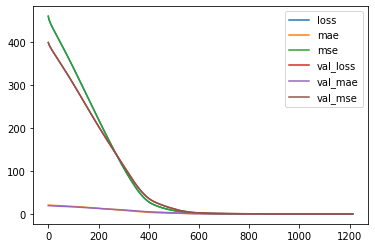

In [23]:
losses = pd.DataFrame(model.history.history)
losses.plot() # Plot the loss

## Model Testing


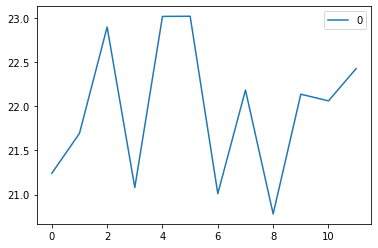

In [24]:
# Tesing the Model based on values from training X = Time , Y = Predicted temperature
testmodel = pd.DataFrame(model.predict(normed_test))
testmodel.plot()

In [25]:
# Predict what the temperature will be after x amount of days
howmany = 90 # 10 days
answer = model.predict([normed_test[0:(howmany % len(normed_test))]])
print(f"The temperature would be {answer.mean()} degrees after {howmany}")

The temperature would be 22.158369064331055 degrees after 90
